In [1]:
#Block for imports and other setting that will be required for the code to run
import os
import sys
import re
import time
import datetime
import random
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df1 = pd.read_csv('new_iso1_group_names.csv',)

In [18]:
df1.head()

,Blend Number,Original Blend Name,Blend Type,Replacement Level,Group_names,PC,GPP,SC,CC,FA,VA,GBA,FBC,QUARTZ,PLC,Cumulative Heat (J/g)
0,0,100% PC,Other,0,X,100,0,0,0,0,0,0,0,0,0,323.16
1,1,80% PC + 20% GPP,Binary,20,PC with GP,80,20,0,0,0,0,0,0,0,0,297.77
2,2,70% PC + 30% GPP,Binary,30,PC with GP,70,30,0,0,0,0,0,0,0,0,311.40
3,3,60% PC + 40% GPP,Binary,40,PC with GP,60,40,0,0,0,0,0,0,0,0,265.35
4,4,50% PC + 50% GPP,Binary,50,PC with GP,50,50,0,0,0,0,0,0,0,0,225.05


In [3]:
df1.head()

,Blend Number,Original Blend Name,Blend Type,Replacement Level,Group_names,PC,GPP,SC,CC,FA,VA,GBA,FBC,QUARTZ,PLC,Cumulative Heat (J/g)
0,0,100% PC,Other,0,X,100,0,0,0,0,0,0,0,0,0,323.16
1,1,80% PC + 20% GPP,Binary,20,Group_1_PC_GP,80,20,0,0,0,0,0,0,0,0,297.77
2,2,70% PC + 30% GPP,Binary,30,Group_1_PC_GP,70,30,0,0,0,0,0,0,0,0,311.40
3,3,60% PC + 40% GPP,Binary,40,Group_1_PC_GP,60,40,0,0,0,0,0,0,0,0,265.35
4,4,50% PC + 50% GPP,Binary,50,Group_1_PC_GP,50,50,0,0,0,0,0,0,0,0,225.05


In [4]:
# Create a mapping dictionary to rename groups for better clarity
rename_mapping = {
    'Group_1_PC_GP': 'PC with GP',
    'Group_3_PC_Q': 'PC with Quartz',
    'Group_2_PLC_GPP': 'PLC with GP',  # Adjust based on actual group naming
    'Group_4_PLC_Q': 'PLC with Quartz',
    'Group_5_3_PC_30': 'Ternary with 30% PC',
    'Group_6_3_PC_40': 'Ternary with 40% PC',
    'Group_7_3_PC_50': 'Ternary with 50% PC',
    'Group_8_3_PLC_30': 'Ternary with 30% PLC',
    'Group_9_3_PLC_40': 'Ternary with 40% PLC',
    'Group_10_3_PLC_50': 'Ternary with 50% PLC',
    'Group_11_3_PC_10': 'Ternary with 10% PC',
    'Group_12_3_PC_20': 'Ternary with 20% PC',
}

# Rename the values in the Group_names column using the mapping
df1['Group_names'] = df1['Group_names'].replace(rename_mapping)

# Verify the changes
print("Unique Group Names After Renaming:")
print(df1['Group_names'].unique())

Unique Group Names After Renaming:
['X' 'PC with GP' 'Ternary with 10% PC' 'Ternary with 20% PC'
 'Ternary with 30% PC' 'Ternary with 40% PC' 'Ternary with 50% PC'
 'PC with Quartz' 'PLC with GP' 'Ternary with 40% PLC'
 'Ternary with 50% PLC' 'Ternary with 30% PLC' 'PLC with Quartz']


In [5]:
# Count the number of entries in each group
group_counts = df1.groupby('Group_names').size().reset_index(name='Count')
print("\nGroup Counts:")
print(group_counts)


Group Counts:
             Group_names  Count
0             PC with GP      6
1         PC with Quartz      6
2            PLC with GP      5
3        PLC with Quartz      5
4    Ternary with 10% PC      1
5    Ternary with 20% PC      1
6    Ternary with 30% PC     26
7   Ternary with 30% PLC     23
8    Ternary with 40% PC      4
9   Ternary with 40% PLC      4
10   Ternary with 50% PC      4
11  Ternary with 50% PLC      4
12                     X      3


In [6]:
group_summary = df1.groupby('Group_names')['Cumulative Heat (J/g)'].agg(['mean', 'median', 'std']).reset_index()
print("\nCumulative Heat Summary by Group:")
print(group_summary)


Cumulative Heat Summary by Group:
             Group_names        mean   median         std
0             PC with GP  246.138333  245.200   56.426974
1         PC with Quartz  229.538333  240.330   57.794374
2            PLC with GP  246.232000  251.610   33.929140
3        PLC with Quartz  256.506000  264.260   38.358624
4    Ternary with 10% PC  115.700000  115.700         NaN
5    Ternary with 20% PC  149.980000  149.980         NaN
6    Ternary with 30% PC  176.442692  174.150   19.871955
7   Ternary with 30% PLC  168.736957  159.340   20.570325
8    Ternary with 40% PC  198.137500  197.655    9.658493
9   Ternary with 40% PLC  196.250000  191.225   11.816838
10   Ternary with 50% PC  226.557500  229.940    7.989712
11  Ternary with 50% PLC  222.070000  221.350    3.731559
12                     X  212.516667  303.150  174.597601


In [7]:
# Calculate mean cumulative heat for each group
group_mean = df1.groupby('Group_names')['Cumulative Heat (J/g)'].mean().reset_index()
print("Mean Cumulative Heat by Group:")
print(group_mean)

Mean Cumulative Heat by Group:
             Group_names  Cumulative Heat (J/g)
0             PC with GP             246.138333
1         PC with Quartz             229.538333
2            PLC with GP             246.232000
3        PLC with Quartz             256.506000
4    Ternary with 10% PC             115.700000
5    Ternary with 20% PC             149.980000
6    Ternary with 30% PC             176.442692
7   Ternary with 30% PLC             168.736957
8    Ternary with 40% PC             198.137500
9   Ternary with 40% PLC             196.250000
10   Ternary with 50% PC             226.557500
11  Ternary with 50% PLC             222.070000
12                     X             212.516667


In [8]:
# For PC-based blends, baseline is 'PC with Quartz'
# For PLC-based blends, baseline is 'PLC with Quartz'
baseline_pc = round(group_mean[group_mean['Group_names'] == 'PC with Quartz']['Cumulative Heat (J/g)'].values[0],2)
baseline_plc = round(group_mean[group_mean['Group_names'] == 'PLC with Quartz']['Cumulative Heat (J/g)'].values[0],2)

print("\nBaseline PC (PC with Quartz):", baseline_pc)
print("Baseline PLC (PLC with Quartz):", baseline_plc)


Baseline PC (PC with Quartz): 229.54
Baseline PLC (PLC with Quartz): 256.51


In [9]:
#Define relevant groups (excluding the Quartz-based baselines)

pc_groups = ['PC with GP', 'Ternary with 30% PC', 'Ternary with 40% PC', 'Ternary with 50% PC','Ternary with 10% PC' ,'Ternary with 20% PC']
plc_groups = ['PLC with GP', 'Ternary with 30% PLC', 'Ternary with 40% PLC', 'Ternary with 50% PLC']

In [10]:
#  Create a new column 'Delta_Heat' in the group_mean DataFrame by comparing against the baseline
def calc_diff(row):
    if row['Group_names'] in pc_groups:
        return row['Cumulative Heat (J/g)'] - baseline_pc
    elif row['Group_names'] in plc_groups:
        return row['Cumulative Heat (J/g)'] - baseline_plc
    else:
        # For baseline groups (and any others), return None or 0
        return None

group_mean['Delta_Heat'] = group_mean.apply(calc_diff, axis=1)

print("\nGroup Mean with ΔHeat (Difference relative to Quartz-based binary blend):")
print(group_mean)


Group Mean with ΔHeat (Difference relative to Quartz-based binary blend):
             Group_names  Cumulative Heat (J/g)  Delta_Heat
0             PC with GP             246.138333   16.598333
1         PC with Quartz             229.538333         NaN
2            PLC with GP             246.232000  -10.278000
3        PLC with Quartz             256.506000         NaN
4    Ternary with 10% PC             115.700000 -113.840000
5    Ternary with 20% PC             149.980000  -79.560000
6    Ternary with 30% PC             176.442692  -53.097308
7   Ternary with 30% PLC             168.736957  -87.773043
8    Ternary with 40% PC             198.137500  -31.402500
9   Ternary with 40% PLC             196.250000  -60.260000
10   Ternary with 50% PC             226.557500   -2.982500
11  Ternary with 50% PLC             222.070000  -34.440000
12                     X             212.516667         NaN


In [13]:
import plotly.express as px

# Interactive bar chart for mean cumulative heat
fig = px.bar(
    group_mean,
    x="Group_names",
    y="Cumulative Heat (J/g)",
    title="Interactive Mean Cumulative Heat by Group",
    labels={"Group_names": "Group", "Cumulative Heat (J/g)": "Mean Cumulative Heat (J/g)"},
    text="Cumulative Heat (J/g)"
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [14]:
# Calculate percentage difference relative to baseline
def calc_percent_diff(row):
    if row['Group_names'] in pc_groups:
        return (row['Delta_Heat'] / baseline_pc) * 100 if baseline_pc != 0 else None
    elif row['Group_names'] in plc_groups:
        return (row['Delta_Heat'] / baseline_plc) * 100 if baseline_plc != 0 else None
    else:
        return None

group_mean['Percent_Difference'] = group_mean.apply(calc_percent_diff, axis=1)

# Filter out baseline groups (which have no ΔHeat) for visualization
delta_df = group_mean.dropna(subset=['Delta_Heat']).copy()

# Create an annotation column that combines ΔHeat and percentage difference
delta_df['Annotation'] = delta_df.apply(
    lambda row: f"{row['Delta_Heat']:.2f} J/g<br>{row['Percent_Difference']:.1f}%", axis=1
)

# --- Create the Interactive Bar Chart ---
fig = px.bar(
    delta_df,
    x="Group_names",
    y="Delta_Heat",
    title="Interactive ΔHeat Relative to Quartz-Based Binary Blends",
    labels={"Group_names": "Group", "Delta_Heat": "ΔHeat (J/g)"},
    color="Delta_Heat",
    color_continuous_scale="RdBu"
)

# Add annotations to the bars
fig.update_traces(text=delta_df['Annotation'], textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

#### 🔍 Insight: ΔHeat Relative to Quartz-Based Binary Blends

This interactive bar chart highlights how each blend group performs relative to its Quartz-based baseline:

- **Positive ΔHeat values** indicate that the SCMs in that group contribute additional hydration energy beyond the baseline binder (PC or PLC).
- **Percentage difference** provides a relative measure of how much improvement (or reduction) is achieved in heat release.
- For example, groups like *Ternary with 50% PC* and *PC with GP* show strong heat contribution, suggesting highly reactive SCM interactions.
- In contrast, smaller ΔHeat or percentage gains may indicate limited reactivity or possible dilution effects.
- This comparison avoids cross-binder confusion by ensuring PC and PLC groups are only compared with their respective baselines.

Use this insight to prioritize **efficient and reactive blend designs** while maintaining binder-type consistency.


In [16]:
import plotly.express as px

# Filter to only the 8 relevant groups
relevant_groups = [
    'PC with GP', 'PLC with GP',
    'Ternary with 30% PC', 'Ternary with 40% PC', 'Ternary with 50% PC',
    'Ternary with 30% PLC', 'Ternary with 40% PLC', 'Ternary with 50% PLC'
]

# Filtered DataFrame for plotting
box_df = df1[df1['Group_names'].isin(relevant_groups)]

# Create interactive boxplot
fig = px.box(
    box_df,
    x="Group_names",
    y="Cumulative Heat (J/g)",
    color="Group_names",
    title="📦 Interactive Boxplot: Cumulative Heat Distribution by Group",
    labels={"Group_names": "Group", "Cumulative Heat (J/g)": "Cumulative Heat (J/g)"},
    points="all"  # shows all data points as scatter
)

fig.update_layout(
    showlegend=False,
    xaxis_tickangle=-45,
    width=1000,
    height=600
)
fig.show()


#### 📦 Insight:
This box plot shows how cumulative heat values are distributed within each group. Groups like *Ternary with 50% PC* show a tight range (more consistent behavior), while others like *PLC with GP* display wider spread, suggesting variability in reactivity. Outliers may indicate inconsistent mix performance or experimental anomalies.


## PREDICTIVE MODEL 

In [19]:
# STEP 1: Filter to relevant groups
relevant_groups = [
    'PC with GP', 'PLC with GP',
    'Ternary with 30% PC', 'Ternary with 40% PC', 'Ternary with 50% PC',
    'Ternary with 30% PLC', 'Ternary with 40% PLC', 'Ternary with 50% PLC'
]

composition_cols = ['PC', 'PLC', 'GPP', 'FA', 'SC', 'CC', 'VA', 'GBA', 'FBC']
df_model = df1[df1['Group_names'].isin(relevant_groups)][composition_cols + ['Cumulative Heat (J/g)']].dropna()

# STEP 2: Define input features (X) and target variable (y)
X = df_model[composition_cols]
y = df_model['Cumulative Heat (J/g)']

# STEP 3: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 4: Train Multiple Models
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (Degree 2)': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    results.append({'Model': name, 'R²': r2, 'RMSE': rmse, 'MAE': mae})

# STEP 5: Create DataFrame of Results
results_df = pd.DataFrame(results)
display(results_df)



,Model,R²,RMSE,MAE
0,Linear Regression,0.909785,11.041933,9.041400
1,Polynomial Regression (Degree 2),0.841749,14.624467,12.519684
2,Random Forest,0.872235,13.140516,9.853176



#### 🤖 Insight: Model Comparison for Predicting Cumulative Heat

Among the three models tested, **Linear Regression** provided the best performance, achieving an R² of 0.91. This suggests that the relationship between binder/SCM composition and cumulative heat is largely linear.

- Polynomial Regression did not improve the fit, indicating limited non-linear interactions or potential overfitting.
- Random Forest was moderately effective but still lagged behind linear regression, implying that the data structure is well-captured by simpler models.

Further analysis (e.g., feature importance) may help refine which SCMs contribute most to heat evolution.


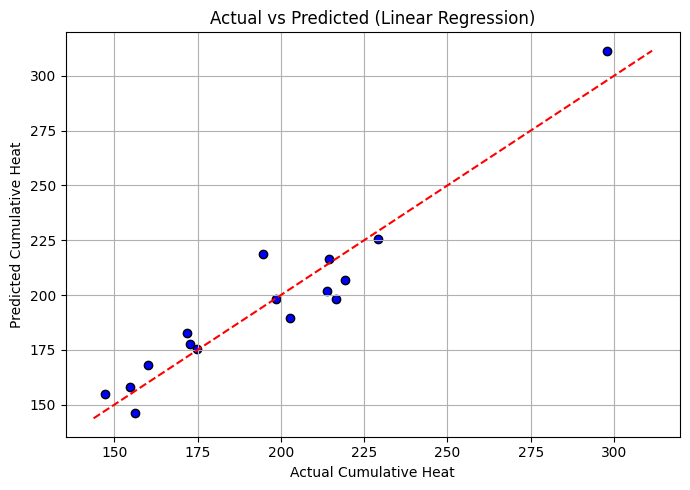

In [20]:
import matplotlib.pyplot as plt

# Use best model: Linear Regression
best_model = LinearRegression()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, c='blue', edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Cumulative Heat")
plt.ylabel("Predicted Cumulative Heat")
plt.title("Actual vs Predicted (Linear Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\raksh\AppData\Local\Temp\ipykernel_40348\4029540607.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




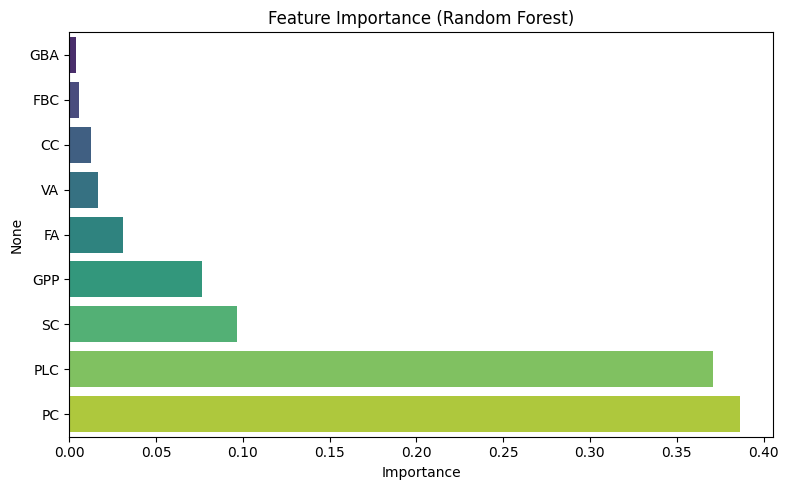

In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

import pandas as pd
import seaborn as sns

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Add new models to your dictionary
extra_models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'XGBoost Regressor': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5)
}

# Merge with existing model dictionary if needed
all_models = {**models, **extra_models}

# Evaluate all models
extended_results = []

for name, model in all_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    extended_results.append({'Model': name, 'R²': r2, 'RMSE': rmse, 'MAE': mae})

# Display all model performance results
extended_results_df = pd.DataFrame(extended_results).sort_values('R²', ascending=False)
display(extended_results_df)


c:\Users\raksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e+02, tolerance: 7.833e+00



,Model,R²,RMSE,MAE
4,Lasso Regression,0.909965,11.030918,9.037187
3,Ridge Regression,0.909807,11.040640,9.041446
0,Linear Regression,0.909785,11.041933,9.041400
2,Random Forest,0.872235,13.140516,9.853176
5,XGBoost Regressor,0.869772,13.266555,9.927687
1,Polynomial Regression (Degree 2),0.841749,14.624467,12.519684
6,KNN Regressor,0.735884,18.893146,14.377250


#### 🤖 Insight: Extended Model Comparison for Cumulative Heat Prediction

With the inclusion of regularized and advanced ML models, **Lasso Regression emerged as the top performer**, achieving the highest R² (0.91) and lowest RMSE and MAE. Interestingly, **Linear and Ridge Regression** followed very closely, confirming the presence of a **strong linear trend** in how SCM proportions affect cumulative heat evolution.

- Tree-based models like **Random Forest** and **XGBoost** performed reasonably well but didn’t outperform the linear models.
- **Polynomial Regression** showed a drop in performance, possibly due to overfitting on small samples.
- **KNN** was the weakest, likely due to its sensitivity to high dimensional data and lack of scaling.

This analysis suggests that simpler models not only perform best but also offer easier interpretability — a plus for industrial deployment and client transparency.


Best alpha: 0.00010
Final Lasso Model (alpha=0.00010)
R²: 0.9098, RMSE: 11.04, MAE: 9.04


c:\Users\raksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.844e+02, tolerance: 7.833e+00

c:\Users\raksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.844e+02, tolerance: 7.833e+00



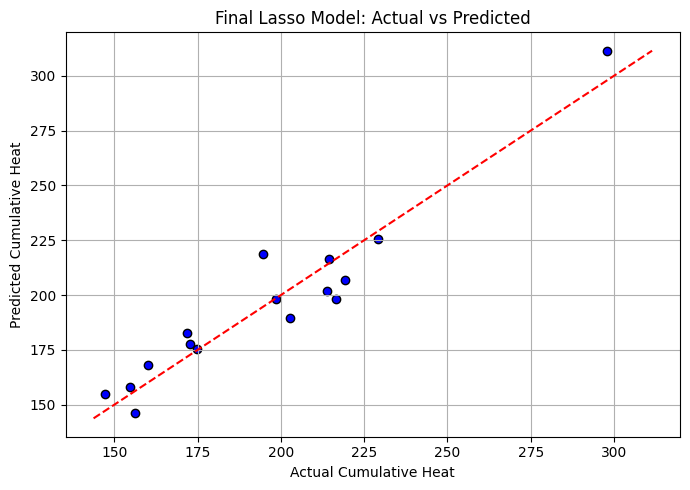

In [25]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Try multiple alpha values on a logarithmic scale
alphas = np.logspace(-4, 1, 50)

# Step 1: LassoCV with 5-fold cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

# Step 2: Best alpha & model refit
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha:.5f}")

# Step 3: Final model evaluation
final_model = Lasso(alpha=best_alpha)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Lasso Model (alpha={best_alpha:.5f})")
print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Optional: Plot predictions vs actual
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, edgecolor='k', color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Cumulative Heat")
plt.ylabel("Predicted Cumulative Heat")
plt.title("Final Lasso Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\raksh\AppData\Local\Temp\ipykernel_40348\3383137596.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




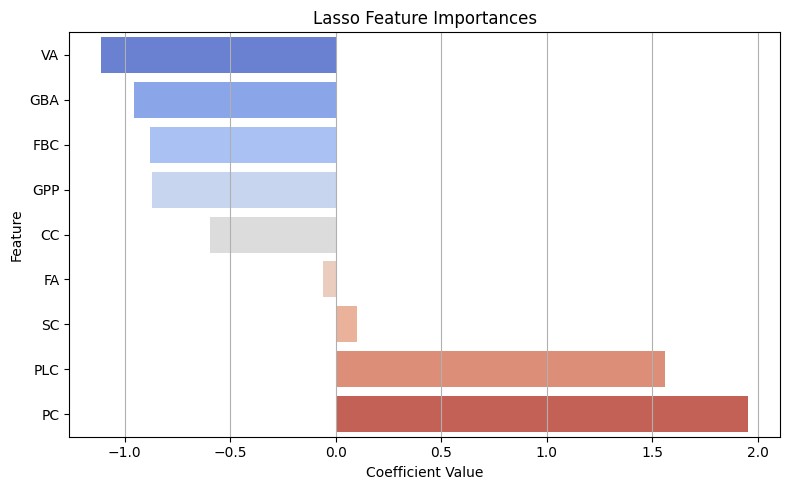

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract feature names and coefficients from final tuned Lasso model
lasso_coef = pd.Series(final_model.coef_, index=X.columns)

# Filter out zero-coefficient features (Lasso does this!)
nonzero_coefs = lasso_coef[lasso_coef != 0].sort_values(ascending=True)

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=nonzero_coefs, y=nonzero_coefs.index, palette='coolwarm')
plt.title("Lasso Feature Importances")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


#### 🧠 Insight: Lasso Model Feature Importances

This plot shows the non-zero coefficients selected by the Lasso Regression model. Higher absolute values indicate a stronger influence on cumulative heat evolution.

- **Positive coefficients** (e.g., PC, GPP) indicate features that increase heat.
- **Negative coefficients** (if any) suggest features that slightly reduce heat when increased.
- Zeroed-out features were dropped by Lasso as **not significantly contributing**.

This provides a clear, interpretable map of which SCMs are thermally active — and supports better material selection in mix design.


In [42]:
def predict_heat_from_user():
    print("📋 Welcome to the Cumulative Heat Predictor!")
    print("Enter the % composition for each material. It will stop once the total hits 100%. Leave blank to skip.\n")

    materials = ['PC', 'PLC', 'GPP', 'FA', 'SC', 'CC', 'VA', 'GBA', 'FBC']
    labels = {
        'PC': " Percent PC: ",
        'PLC': " Percent PLC: ",
        'GPP': " Percent GPP (Glass Pozzolan): ",
        'FA': " Percent FA (Fly Ash): ",
        'SC': " Percent SC (Slag Cement): ",
        'CC': " Percent CC (Calcined Clay): ",
        'VA': " Percent VA (Volcanic Ash): ",
        'GBA': " Percent GBA (Ground Brick Aggregate): ",
        'FBC': " Percent FBC Ash: "
    }

    blend = {}
    total = 0.0

    for mat in materials:
        remaining = 100 - total
        if remaining <= 0:
            print(" Total reached 100%. Stopping further input.\n")
            break

        prompt = labels[mat] + f"(Remaining: {remaining:.2f}%) "
        user_input = input(prompt).strip()

        if user_input == "":
            blend[mat] = 0
            continue

        try:
            val = float(user_input)
            if val < 0 or val > remaining:
                print(f" Value must be between 0 and {remaining:.2f}. Setting {mat} to 0.")
                val = 0
        except ValueError:
            print(f" Invalid input for {mat}. Setting to 0.")
            val = 0

        blend[mat] = val
        total += val

    print(f"\n Final Blend Total: {total:.2f}%")

    if not 98 <= total <= 102:
        print(" Warning: Blend doesn't sum to ~100%. Please check the inputs.\n")
        return

    # Ensure all required columns are present and in order
    required_columns = ['PC', 'PLC', 'GPP', 'FA', 'SC', 'CC', 'VA', 'GBA', 'FBC']
    for col in required_columns:
        if col not in blend:
            blend[col] = 0

    input_df = pd.DataFrame([[blend[col] for col in required_columns]], columns=required_columns)

    # Show user inputs
    print("\n Blend Composition Summary:")
    for comp, val in blend.items():
        if val > 0:
            print(f"  - {comp}: {val:.2f}%")

    # Predict cumulative heat
    prediction = final_model.predict(input_df)[0]
    print(f"\n Estimated Cumulative Heat: **{round(prediction, 2)} J/g** \n")


In [43]:
predict_heat_from_user()


📋 Welcome to the Cumulative Heat Predictor!
Enter the % composition for each material. It will stop once the total hits 100%. Leave blank to skip.

 Total reached 100%. Stopping further input.


 Final Blend Total: 100.00%

 Blend Composition Summary:
  - PC: 60.00%
  - GPP: 20.00%
  - FA: 10.00%
  - SC: 6.00%
  - CC: 2.00%
  - VA: 2.00%

 Estimated Cumulative Heat: **268.7 J/g** 



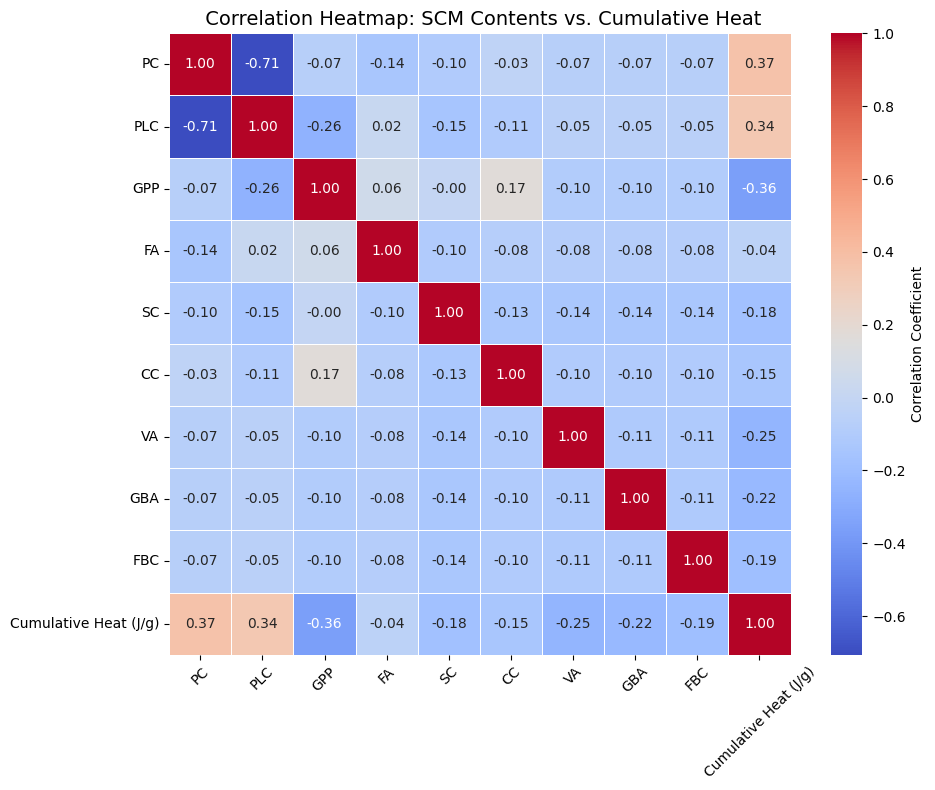

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and target into one DataFrame
correlation_data = df1[[
    'PC', 'PLC', 'GPP', 'FA', 'SC', 'CC', 'VA', 'GBA', 'FBC', 'Cumulative Heat (J/g)'
]].dropna()

# Compute correlation matrix
corr_matrix = correlation_data.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title(" Correlation Heatmap: SCM Contents vs. Cumulative Heat", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### 📊 Insight: Correlation of SCMs with Cumulative Heat

This heatmap shows how strongly each SCM (and binder) percentage correlates with the **cumulative heat evolution**:

- **Positive correlations** (e.g., PC, GPP) suggest these materials tend to **increase heat** when their proportion increases.
- **Negative correlations** may indicate SCMs that **reduce heat** or act as diluents.
- Features with **strong inter-correlation** (e.g., PC vs PLC or FA vs CC) may need attention due to potential multicollinearity.

This chart helps validate model findings and informs future optimization strategies by highlighting which components are most thermally active.


In [46]:
import plotly.express as px
import plotly.figure_factory as ff

# Calculate correlation
corr_matrix = df1.corr().round(2)
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns.tolist(),
    y=corr_matrix.index.tolist(),
    colorscale='RdBu',
    showscale=True,
    zmin=-1, zmax=1
)
fig.update_layout(title_text="📈 Correlation Matrix (Interactive)", width=700, height=700)
fig.show()


ValueError: could not convert string to float: '100% PC'

<Axes: >

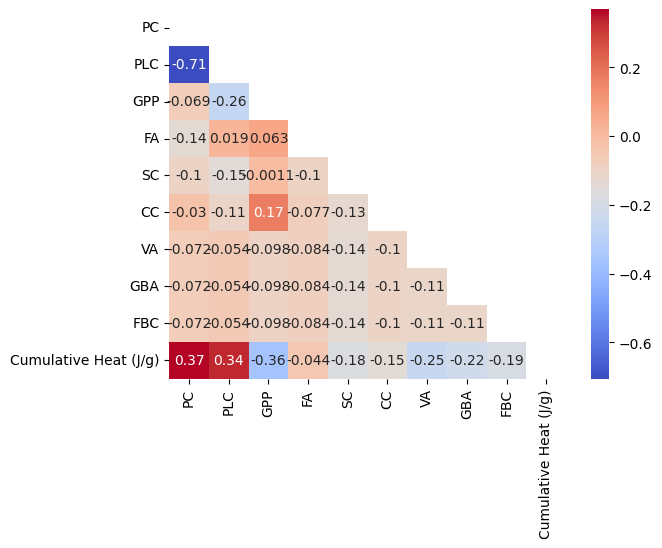

In [47]:
# Optional: Lower triangle heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm")
